<a href="https://colab.research.google.com/github/judelo/algosto/blob/master/python/TP_SEM_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Algorithmes Stochastiques, SEM, N-SEM, EM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

In [2]:
from TP_SEM_EM import *

$\newcommand{\si}{\sigma}
\newcommand{\al}{\alpha}
\newcommand{\tta}{\theta}
\newcommand{\Tta}{\Theta}
\newcommand{\Si}{\Sigma}
\newcommand{\ld}{\ldots}
\newcommand{\cd}{\cdots}
\newcommand{\cN}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\p}{\mathbb{P}}
\newcommand{\f}{\frac}
\newcommand{\ff}{\frac{1}}
\newcommand{\ds}{\displaystyle}
\newcommand{\bE}{\mathbf{E}}
\newcommand{\bF}{\mathbf{F}}
\newcommand{\ii}{\mathrm{i}}
\newcommand{\me}{\mathrm{e}}
\newcommand{\hsi}{\hat{\sigma}}
\newcommand{\hmu}{\hat{\mu}}
\newcommand{\ste}{\, ;\, }
\newcommand{\op}{\operatorname} 
\newcommand{\argmax}{\op{argmax}}
\newcommand{\lfl}{\lfloor}
\newcommand{\ri}{\right}
$


## Rappels de cours
### Mélange de gaussiennes
On rappelle qu'une mixture gaussienne a une densité de la forme 
$$x\mapsto \sum_{k=1}^K\alpha_kf_{\mu_k,\sigma_k}(x)=\sum_{k=1}^K\alpha_k\frac{1}{\sqrt{2\pi \sigma_k^2}}\mathrm{e}^{-\frac{(x-\mu_k)^2}{2\sigma_k^2}}.$$

On commence par définir une fonction qui permet d'évaluer la densité théorique d'un mélange de gaussiennes sur une grille x. 

In [3]:
# Calcul de la densité théorique d'un GMM sur une grille x                               
def densite_theorique(K,mu,sigma,alpha,x):
    y=np.zeros(len(x))
    for j in range(K):
        y+=alpha[j]*sps.norm.pdf(x,loc=mu[j],scale=sigma[j])
    return y

### Simulation des données

Pour simuler une mixture gaussienne, on commence par fixer $K\geq 1$, et par choisir un paramètre $\theta:=(\alpha_k,\mu_k,\sigma_k)_{1\le k\le K}$, avec $\mu_1, \ldots, \mu_K\in \R$, $\sigma_1, \ldots, \sigma_K>0$ et $\alpha_1, \ldots, \al_K>0$ tels que $\al_1+\cd+\al_K=1$. On 
tire au hasard des données $(z_1,x_1), \ld,(z_n,x_n
)$, copies indépendantes du vecteur aléatoire $(Z,X)$ de loi $\p_\theta$ donnée par :
- $Z\in \{1, \ld, K\}$ de loi $(\al_1, \ld, \al_K)$,
- pour tout $k\in \{1, \ld, K\}$, conditionellement à $Z=k$, $X\sim \cN(\mu_k, \si_k^2)$. 

Notons que le passage de $X$ à $Z$ se fait avec la formule de Bayes :  pour tout    $x\in \R$ et $k\in \{1, \ld, K\}$,    
$$\label{eq:Oleron1}\p_\theta(Z=k | X=x)\;=\;\f{\al_kf_{\mu_k,\si_k}(x)}{\sum_{l=1}^K\al_lf_{\mu_l,\si_l}(x)}.$$ 
avec $$f_{\mu,\si}(x):=\ff{\sqrt{2\pi}\si}\me^{-\f{(x-\mu)^2}{2\si^2}}.$$

Les algorithmes  SEM, $N$-SEM, EM ont pour but d'estimer les paramètres $\mu_1, \ld, \mu_K\in \R$, $\si_1, \ld, \si_K>0$ et $\al_1, \ld, \al_K>0$  ainsi que les valeurs des $z_i$ par la seule observation des $x_i$. 

<span style="color:blue">1. Ecrire une fonction `echantillon(K,alpha,mu,sigma,n)` permettant de simuler $n$ réalisations indépendantes d'une telle loi. $K$ est le nombre de gaussiennes, *alpha* le vecteur des paramètres du mélange, *mu* les moyennes et *sigma* les écart-types (ce sont donc des listes de $K$ élements). La fonction doit renvoyer à la fois les Z_i et les X_i, par exemple sous forme de deux listes. Essayer de coder cette fonction SANS BOUCLE FOR.</span>

<span style="color:blue">2. Tester cette fonction avec K=3, alpha=(.4,.3,.3), mu=(-4,4,0), sigma=(1,1,1) et n = 1000 et tracer sur le même graphe l'histogramme des réalisations ainsi obtenues et le mélange correspondant.</span>

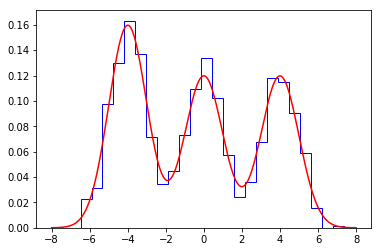

In [4]:
# Simulation des Données    
K=3
alpha_real=[.4,.3,.3]
mu_real=[-4,4,0]
sigma_real=[1,1,1]
n=1000

Z,X=echantillon(K,np.array(mu_real),np.array(sigma_real),alpha_real,n)

plt.hist(X,bins=round(3*n**(.3)),density=1,histtype="step",color = 'b')   # remplacer density par normed si matplotlib <2.2

x=np.linspace(-8,8,num=1000)
y=densite_theorique(K,mu_real,sigma_real,alpha_real,x)
plt.plot(x,y,"r")

### Estimation des paramètres dans le cas où l'on connaît les $z_i$
  L'estimateur du Maximum de Vraisemblance (EMV), étant données les observations $(z_i,x_i)_{1\le i\le n}$, fournit les estimations suivantes pour le paramètre $\tta=(\al_k,\mu_k,\si_k)_{1\le k\le K}$:  pour tout $k=1,\ld, K$,  
 $$\widehat{\al}_k=\f{|\{i\ste z_i=k\}|}{n},$$ 
 $$\widehat{\mu}_k=\ff{n\widehat{\al}_k}\sum_{i\ste z_i=k} x_i,$$   
 $$\widehat{\si}^2_k=\ff{n\widehat{\al}_k}\sum_{i\ste z_i=k} (x_i-\widehat{\mu}_k)^2.$$
 
<span style="color:blue"> 3. Ecrire une fonction *estimation(K,Z,X)* qui calcule l'EMV dans le cas où l'on connait les  $(z_i,x_i)_{1\le i\le n}$. Cette fonction doit retourner les trois listes de taille K (alpha,mu,sigma). Appliquer cette fonction aux réalisations de la question précédente et comparer les valeurs estimées avec les valeurs réelles du mélange.</span>

In [5]:
(alpha_estime,mu_estime,sigma_estime)=estimation(K,Z,X)

print("\nVrai alpha et alpha estimé :")
print(alpha_real,alpha_estime)

print("\nVrai mu et mu estimé :")
print(mu_real,np.around(mu_estime,decimals=3))

print("\nVrai sigma et sigma estimé :")
print(sigma_real,np.around(sigma_estime,decimals=3))



Vrai alpha et alpha estimé :
[0.4, 0.3, 0.3] [0.397, 0.295, 0.308]

Vrai mu et mu estimé :
[-4, 4, 0] [-3.973  4.     0.009]

Vrai sigma et sigma estimé :
[1, 1, 1] [0.996 0.957 0.972]



## Algorithmes

Dans la suite de ce TP, on souhaite appliquer les algorithmes SEM, N-SEM et EM aux données $x_1, \ld, x_n$ pour estimer $\tta$. Estimer alors les $z_i$ : pour tout $i$, on choisit $$z_i:=\argmax_k \p_\theta(Z=k | X=x_i).$$
Comparer alors les valeurs de $\tta$ ainsi que des $z_i$ à leurs vraies valeurs.

### Algorithme SEM
- initialisation arbitraire des classes $z_i\in \{1,\ldots,K\}$
- répéter un grand nombre de fois:
    - a) calculer $\widehat{\theta}$
    - b) pour tout $i=1,\ldots,n$, tirer la valeur de $z_i$ selon la loi  $$\mathbb{P}_{\widehat\theta}(Z_i=\bullet | X_i=x_i)$$ 

<span style="color:blue"> 4. Ecrire une fonction `SEM(nbpas,K,x)` qui implémente l'algorithme précédent avec L étapes. Appliquer cette fonction aux réalisations de la question précédente et comparer les valeurs estimées avec les valeurs réelles du mélange.</span>

In [6]:
L=int(100)
print("\nSEM :")
alpha_est,mu_est,sigma_est =0,0,0
(alpha_est,mu_est,sigma_est)=SEM(L,K,X)


SEM :


In [7]:
print("\nVrai alpha et alpha estimé :")
print(alpha_real,alpha_est)

print("\nVrai mu et mu estimé :")
print(mu_real,np.around(mu_est,decimals=3))

print("\nVrai sigma et sigma estimé :")
print(sigma_real,np.around(sigma_est,decimals=3))


Vrai alpha et alpha estimé :
[0.4, 0.3, 0.3] [0.28, 0.399, 0.321]

Vrai mu et mu estimé :
[-4, 4, 0] [ 4.109 -3.969  0.121]

Vrai sigma et sigma estimé :
[1, 1, 1] [0.85  0.99  1.016]


### Algorithme SEM à $N$ tirages
- dupliquer $N$ fois le jeu d'observations $(x_1, \ld, x_n)$, qui devient donc $(x_{i}^{(j)})_{1\le i\le n,\, 1\le j\le N}$
- appliquer SEM à ce jeu de données étendu 

<span style="color:blue">5. Ecrire une fonction `NSEM(N,L,K,x)` qui implémente l'algorithme précédent. Appliquer cette fonction aux réalisations de la question précédente et comparer les valeurs estimées avec les valeurs réelles du mélange.</span>

In [8]:
L=100
N=10
print("\nN-SEM :")
(alpha_est,mu_est,sigma_est)=NSEM(N,L,K,X)       


N-SEM :


In [9]:
print("\nVrai alpha et alpha estimé :")
print(alpha_real,alpha_est)

print("\nVrai mu et mu estimé :")
print(mu_real,np.around(mu_est,decimals=3))

print("\nVrai sigma et sigma estimé :")
print(sigma_real,np.around(sigma_est,decimals=3))


Vrai alpha et alpha estimé :
[0.4, 0.3, 0.3] [0.3986, 0.2668, 0.3346]

Vrai mu et mu estimé :
[-4, 4, 0] [ 0.609  2.767 -4.111]

Vrai sigma et sigma estimé :
[1, 1, 1] [2.59  2.083 0.889]


### Algorithme EM
- initialisation arbitraire du paramètre $\theta_0$, 
- étant donné le paramètre $\theta_t$, répéter pour $t=0,1,2,\dots$ et jusqu'à convergence
    - Calcul de la matrice 
    $$\left[\p_{\tta_{t}}(Z=k | X=x_i)\right]_{1\le i\le n, \, 1\le k\le K}=\left[\f{\al_k^tf_{\mu_k^t,\si^t_k}(x_i)}{\sum_{l=1}^K\al_l^tf_{\mu_l^t,\si_l^t}(x_i)}\right]_{1\le i\le n, \, 1\le k\le K}$$ 
    - Calcul de $\tta_{t+1}$ : pour tout $k=1,\ld,K$, 
    $$\al_k^{t+1}=\ff n\sum_{i=1}^n \p_{\tta_{t}}(Z=k | X=x_i),$$
 $$\mu_k^{t+1}=\ff{n\al_k^{t+1}}\sum_{i=1}^n \p_{\tta_{t}}(Z=k | X=x_i)x_i,$$
 $$(\si_k^{t+1})^2=\ff{n\al_k^{t+1}}\sum_{i=1}^n \p_{\tta_{t}}(Z=k | X=x_i)(x_i-\mu_k^{t+1})^2.$$
 
<span style="color:blue">6. Ecrire une fonction `EM(L,K,x)` qui implémente l'algorithme précédent. Appliquer cette fonction aux réalisations de la question précédente et comparer les valeurs estimées avec les valeurs réelles du mélange.</span>

In [10]:
print("\nEM :")
L=100    
(alpha_est,mu_est,sigma_est)=EM(L,K,X)    


EM :


In [11]:
print("\nVrai alpha et alpha estimé :")
print(alpha_real,alpha_est)

print("\nVrai mu et mu estimé :")
print(mu_real,np.around(mu_est,decimals=3))

print("\nVrai sigma et sigma estimé :")
print(sigma_real,np.around(sigma_est,decimals=3))  


Vrai alpha et alpha estimé :
[0.4, 0.3, 0.3] [0.289722   0.31498844 0.39528956]

Vrai mu et mu estimé :
[-4, 4, 0] [ 4.048  0.027 -3.987]

Vrai sigma et sigma estimé :
[1, 1, 1] [0.9   0.975 0.979]


## EM en dimension supérieure

On se place cette fois en dimension deux. Chaque gaussienne du mélange est déterminée par sa moyenne (un vecteur de $\R^2$ et sa matrice de covariance (une matrice $2\times 2$).

<span style="color:blue">7. Ecrire une nouvelle fonction `échantillon2d` permettant d'échantillonner $n$ fois le mélange de gaussiennes de dimension 2 ayant les caractéristiques suivantes : </span>
- K=3
- alpha=(.5,.3,.2)
- les 3 gaussiennes ont les moyennes $\mu_1=(-5,-5)$, $\mu_2 = (5,5)$, $\mu_3=(0,0)$. On pourra rassembler ces moyennes dans une liste $mu=[[-5,-5],[5,5],[0,0]]$
- les 3 gaussiennes ont la même covariance $$\begin{pmatrix} 1 & 0.5 \\ 0.5 & 1\end{pmatrix}.$$ 

<span style="color:blue">8. Appliquer la fonction précédentes pour réaliser une liste $X$ constituée de $n$ observations du mélange (donc $X$ est une liste de vecteurs de dimension 2).</span>

<span style="color:blue">9. Ecrire une nouvelle fonction `EM2d` permettant d'estimer les paramètres du mélange à partir des observations $X$ et comparer le résultat obtenu avec les paramètres réels du mélange.</span>

In [12]:
d=2
K=3
alpha=[.5,.3,.2]
mu=[[-5,-5],[5,5],[0,0]]
covariance=[np.array([[1,.5],[.5,1]])]*K
n=int(5e2)
L=100

(z0,x0)=echantillon2d(K,alpha,mu,covariance,n) 
(alpha_em,mu_em,covariance_em)=EM2d(3,L,x0)

In [13]:
print("\nEstimation de alpha :\n")
print(alpha_em)

print("\nEstimation de mu ")
for k in range(K):
    print("\nClasse "+str(k)+" :")
    print(mu_em[k])

print("\nEstimation de la covariance :")
for k in range(K):
    print("\nClasse "+str(k)+" :")
    print(covariance_em[k])    


Estimation de alpha :

[0.30898164 0.19696508 0.49405328]

Estimation de mu 

Classe 0 :
[4.9112392  5.01049958]

Classe 1 :
[0.15540266 0.19335595]

Classe 2 :
[-5.01162262 -4.98703529]

Estimation de la covariance :

Classe 0 :
[[1.0395603  0.56583594]
 [0.56583594 1.11636197]]

Classe 1 :
[[0.90554236 0.55381872]
 [0.55381872 1.08992319]]

Classe 2 :
[[1.04996874 0.50330021]
 [0.50330021 0.97741673]]
